In [ ]:
import os

from google.colab import drive

drive.mount('/content/drive')


DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive


In [ ]:
!pip install deepctr
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.2/141.2 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 71.7 MB/s eta 0:00:00
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 58.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
import random
import implicit
from sklearn.preprocessing import MinMaxScaler

book_df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/ratings_Books.csv')
book_df.drop(['timestamp'], axis=1, inplace=True)
#df = book_df.drop_duplicates()
grouped_df = df.groupby(['personId', 'contentId']).mean().reset_index()

grouped_df.sample(10)

,personId,contentId,eventStrength
144986,60012234,A3DYB007GTZ74V,5.0
25148,006075186X,A3PWQXT5QGEKN7,4.0
102851,2247399,A1WFZ4ZA68IBOE,5.0
411894,60955228,A366A53KCCOBLS,2.0
251020,60560797,A1N0ZI4CZQ2VTB,5.0
369858,60876107,A3UNL3IN2KIP1T,5.0
680414,61961353,A263Y9TEKGYWO9,5.0
753608,62048651,A18BHB6C2HGW5H,5.0
1040197,7447094,A1JAWC11MRRRT1,4.0
647090,61869767,A2YISGCXG4RZFR,5.0


In [ ]:
grouped_df['personId'] = grouped_df['personId'].astype("category")
grouped_df['contentId'] = grouped_df['contentId'].astype("category")
grouped_df['person_id'] = grouped_df['personId'].cat.codes
grouped_df['content_id'] = grouped_df['contentId'].cat.codes

sparse_content_person = sparse.csr_matrix((grouped_df['eventStrength'].astype(float), (grouped_df['content_id'], grouped_df['person_id'])))
sparse_person_content = sparse.csr_matrix((grouped_df['eventStrength'].astype(float), (grouped_df['person_id'], grouped_df['content_id'])))

model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

alpha = 15
data = (sparse_content_person * alpha).astype('double')

model.fit(data)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
model.item_factors.shape

(33122, 20)

In [ ]:
content_id = 5
n_similar = 10

person_vecs = model.user_factors
content_vecs = model.item_factors

content_norms = np.sqrt((content_vecs * content_vecs).sum(axis=1))

scores = content_vecs.dot(content_vecs[content_id]) / content_norms
top_idx = np.argpartition(scores, -n_similar)[-n_similar:]
similar = sorted(zip(top_idx, scores[top_idx] / content_norms[content_id]), key=lambda x: -x[1])

for content in similar:
    idx, score = content
    print(grouped_df.contentId.loc[grouped_df.content_id == idx].iloc[0])

A00110881F13KCHZX43Z5
A03258121195QFCW90GRO
A11Z5LOC4FORYI
A15OEAHTNF33C
A15KF9BF17B6OJ
A15SJT71K8XTCO
A15OOAQQJYO3ML
A15OO3DS3HSLPS
A142AJVHJ4PF1K
A15NSDYMLYIHYG


In [ ]:
def recommend(person_id, sparse_person_content, person_vecs, content_vecs, num_contents=10):
    # Get the interactions scores from the sparse person content matrix
    person_interactions = sparse_person_content[person_id,:].toarray()
    # Add 1 to everything, so that articles with no interaction yet become equal to 1
    person_interactions = person_interactions.reshape(-1) + 1
    # Make articles already interacted zero
    person_interactions[person_interactions > 1] = 0
    # Get dot product of person vector and all content vectors
    rec_vector = person_vecs[person_id,:].dot(content_vecs.T).toarray()
    
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    # Content already interacted have their recommendation multiplied by zero
    recommend_vector = person_interactions * rec_vector_scaled
    # Sort the indices of the content into order of best recommendations
    content_idx = np.argsort(recommend_vector)[::-1][:num_contents]
    
    # Start empty list to store titles and scores
    titles = []
    scores = []

    for idx in content_idx:
        # Append titles and scores to the list
        titles.append(grouped_df.contentId.loc[grouped_df.content_id == idx].iloc[0])
        scores.append(recommend_vector[idx])

    recommendations = pd.DataFrame({'contentId': titles, 'score': scores})

    return recommendations

In [ ]:
# Get the trained person and content vectors. We convert them to csr matrices
person_vecs = sparse.csr_matrix(model.user_factors)
content_vecs = sparse.csr_matrix(model.item_factors)

# Create recommendations for person with id 50
person_id = 5

recommendations = recommend(person_id, sparse_content_person, person_vecs, content_vecs)

print(recommendations)

        contentId     score
0  A12PBNMVQ03BPF  1.000000
1  A106SEQLOUBN5Z  0.993688
2  A131DI055RJWVF  0.950115
3  A134T9T1N7PZ02  0.903267
4  A12G6V4BYU2PQB  0.884979
5  A1395O9FA4JHOB  0.881452
6  A131W02TOIPL94  0.845495
7  A12CME8F69RXU7  0.842059
8  A15C8LIYOYUF3Q  0.826063
9  A10W4B88G9WUVF  0.808494


In [ ]:
grouped_df.loc[grouped_df['person_id'] == 5].sort_values(by=['eventStrength'], ascending=False)[['contentId', 'eventStrength', 'person_id']]

,contentId,eventStrength,person_id
547,A2MYSL81D3B45A,5.0,5
548,A39E7GHYI3GRBI,4.0,5
549,A3GU296FVDQXW6,4.0,5
550,A8FCG9ERPSOVE,1.0,5


In [ ]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
## for machine learning
from sklearn import metrics, preprocessing
book_df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/ratings_Books.csv')
book_df.drop(['timestamp'], axis=1, inplace=True)
#df = book_df.drop_duplicates()
ratings = book_df.groupby(['personId', 'contentId']).mean().reset_index()
#ratings = ratings[0:500000]
ratings.sample(10)





,reviewers,course_id,rating
328903,By Parmar P,open-source-tools-for-data-science,4.0
343155,By Priyanka P,gcp-fundamentals,5.0
401400,By Shonderla F,agile-atlassian-jira,4.0
26988,By Alessio B,introduction-to-ai,4.0
427765,By Teresa M,technical-support-fundamentals,5.0
328175,By Paola P,everyday-parenting,5.0
88156,By Chhavi,python-for-applied-data-science-ai,5.0
302214,By Nachiket H,wharton-quantitative-modeling,5.0
36299,By Amol T,neuromarketing,5.0
363814,By Robert J C,professional-emails-english,5.0


In [ ]:
g = ratings.groupby('personId')['eventStrength'].count()
top_users = g.sort_values(ascending=False)[:15]
g = ratings.groupby('contentId')['eventStrength'].count()
top_articles = g.sort_values(ascending=False)[:15]
top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='personId')
top_r = top_r.join(top_articles, rsuffix='_r', how='inner', on='contentId')
pd.crosstab(top_r.personId, top_r.contentId, top_r.eventStrength, aggfunc=np.sum)

contentId,A14OJS0VWMOSWO,A1D2C0WDCSHUWZ,A1D5RCOILPC9LX,A1K1JW1C5CUSUZ,A22B13EJTZKCTM,A2F6N60Z96CAJI,A2GBJQ9THOYDAJ,A2TX179XAT5GRP,A3M174IC0VXOS2,A3U7ELIED4WP4R,AFVQZQ8PW0L,AHUT55E980RDR
personId,,,,,,,,,,,,
2007770,NaN,NaN,NaN,5.0,5.0,5.0,NaN,NaN,5.0,NaN,NaN,NaN
2247399,NaN,4.0,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
60098902,5.0,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61537934,NaN,NaN,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.0,NaN
61950726,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0
62024027,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN
62082353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
62255657,NaN,5.0,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN,5.0,NaN
7124015,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
user_enc = LabelEncoder()
ratings['personId'] = user_enc.fit_transform(ratings['personId'].values)
n_users = ratings['personId'].nunique()
item_enc = LabelEncoder()
ratings['contentId'] = item_enc.fit_transform(ratings['contentId'].values)
n_articles = ratings['contentId'].nunique()
ratings['eventStrength'] = ratings['eventStrength'].values.astype(np.float32)

min_rating = min(ratings['eventStrength'])
max_rating = max(ratings['eventStrength'])
n_users, n_articles, min_rating, max_rating


(287808, 604, 1.0, 5.0)

In [ ]:
X = ratings[['personId', 'contentId']].values
y = ratings['eventStrength'].values
#min_max = MinMaxScaler()
#y = min_max.fit_transform(y.reshape(-1,1))[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((404892, 2), (101224, 2), (404892,), (101224,))

In [ ]:
n_factors = 2
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]
y_train

array([5., 5., 5., ..., 5., 5., 5.], dtype=float32)

In [ ]:
## for deep learning
import tensorflow as tf
import tensorflow.keras as keras
from keras import models, layers, utils  
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
def RecommenderV1(n_users, n_articles, n_factors):
    user = Input(name="user",shape=(1,))
    u_emb = layers.Embedding(name='u_emb', input_dim=n_users, output_dim=n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape(name='u', target_shape=(n_factors,))(u_emb)
    
    articles = Input(name="content",shape=(1,))
    m_emb = layers.Embedding(name='m_emb', input_dim=n_articles, output_dim=n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(articles)
    m = Reshape(name='m', target_shape=(n_factors,))(m_emb)
    
    x = Dot(normalize=True,axes=1)([u, m])

    ## embeddings and reshape
    nn_u_emb = layers.Embedding(name="nn_u_emb", input_dim=n_users, output_dim=n_factors)(user)
    nn_u = layers.Reshape(name='nn_u', target_shape=(n_factors,))(nn_u_emb)
    ## embeddings and reshape
    nn_p_emb = layers.Embedding(name="nn_p_emb", input_dim=n_articles, output_dim=n_factors)(articles)
    nn_p = layers.Reshape(name='nn_p', target_shape=(n_factors,))(nn_p_emb)
    ## concat and dense
    nn_xx = layers.Concatenate()([nn_u, nn_p])
    nn_xx = layers.Dense(name="nn_xx", units=int(n_factors/2), activation='relu')(nn_xx)

    # Merge A & B
    y_out = layers.Concatenate()([x, nn_xx])
    y_out = layers.Dense(name="y_out", units=1, activation='relu')(y_out)

    opt = Adam(lr=0.001)
    # Compile
    model = models.Model(inputs=[user, articles], outputs=y_out, name="Neural_CollaborativeFiltering")
    model.compile(optimizer=opt, loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])
    #model.compile("adam", "mse", metrics=[keras.metrics.RootMeanSquaredError()])
    return model

Model: "Neural_CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 content (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 nn_u_emb (Embedding)           (None, 1, 5)         1439035     ['user[0][0]']                   
                                                                                                  
 nn_p_emb (Embedding)           (None, 1, 5)         3020        ['content[0][0]']                
                                                                      

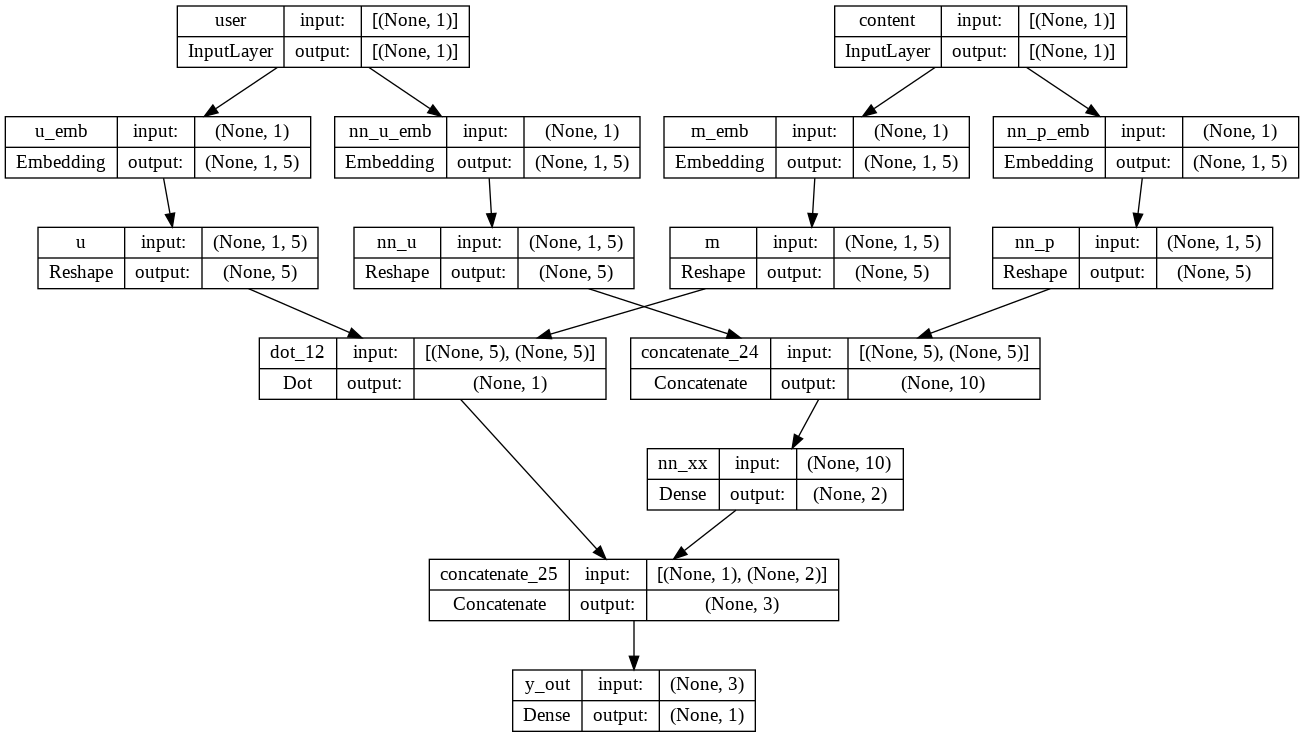

In [ ]:
model = RecommenderV1(n_users, n_articles, n_factors)
model.summary()
utils.plot_model(model, to_file='/content/drive/MyDrive/model/neural_recommender_model.png', show_shapes=True, show_layer_names=True)


In [ ]:
history = model.fit(x=X_train_array, y=y_train, batch_size=256, epochs=10, verbose=2, validation_data=(X_test_array, y_test))
#pred_ans = model.predict(X_test_array, batch_size=256)

Epoch 1/10


InvalidArgumentError: ignored

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
y_pred1 = model.predict(X_test_array, batch_size=256, verbose=1)
pred_ans = np.argmax(y_pred1, axis=1)
#y_pred[100]
#y_test[100]
print("test MSE", round(mean_squared_error(y_test, pred_ans), 4))
print("test RMSE", math.sqrt(round(mean_squared_error(y_test, pred_ans), 4)))
print("test MAE", round(mean_absolute_error(y_test, pred_ans), 4))
pred_ans_1d = np.reshape(pred_ans, 209715)
pred_ans_1d.shape        
np.argsort(np.asarray(pred_ans_1d))[::-1][0:10].tolist()


820/820 [==============================] - 1s 2ms/step
test MSE 19.218
test RMSE 4.383833938460717
test MAE 4.2343


[209714, 69900, 69910, 69909, 69908, 69907, 69906, 69905, 69904, 69903]

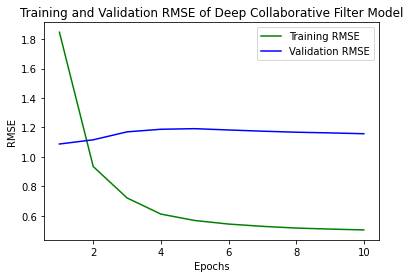

In [ ]:
import matplotlib.pyplot as plt
rmse_train = history.history['root_mean_squared_error']
rmse_val = history.history['val_root_mean_squared_error']
epochs = range(1,11)
plt.plot(epochs, rmse_train, 'g', label='Training RMSE')
plt.plot(epochs, rmse_val, 'b', label='Validation RMSE')
plt.title('Training and Validation RMSE of Deep Collaborative Filter Model')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
import math
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, ndcg_score, dcg_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow.keras as keras
from keras import models, layers, utils
from deepctr.models import DeepFM, xDeepFM, DIN
from deepctr.feature_column import SparseFeat, get_feature_names

sparse_features = ['personId', 'contentId']
target = ['eventStrength']
# 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    ratings[feat] = lbe.fit_transform(ratings[feat])
# 2.count #unique features for each sparse field
fixlen_feature_columns = [SparseFeat(feat, ratings[feat].max(), embedding_dim=10)#.max() + 1, embedding_dim=10)
                              for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

# 3.generate input data for model
train, test = train_test_split(ratings, test_size=0.2)#, random_state=2020)
train_model_input = {name: train[name].values for name in feature_names}
test_model_input = {name: test[name].values for name in feature_names}





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
reviewers (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
course_id (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
sparse_emb_reviewers (Embedding (None, 1, 10)        2878070     reviewers[0][0]                  
__________________________________________________________________________________________________
sparse_emb_course_id (Embedding (None, 1, 10)        6030        course_id[0][0]                  
____________________________________________________________________________________________

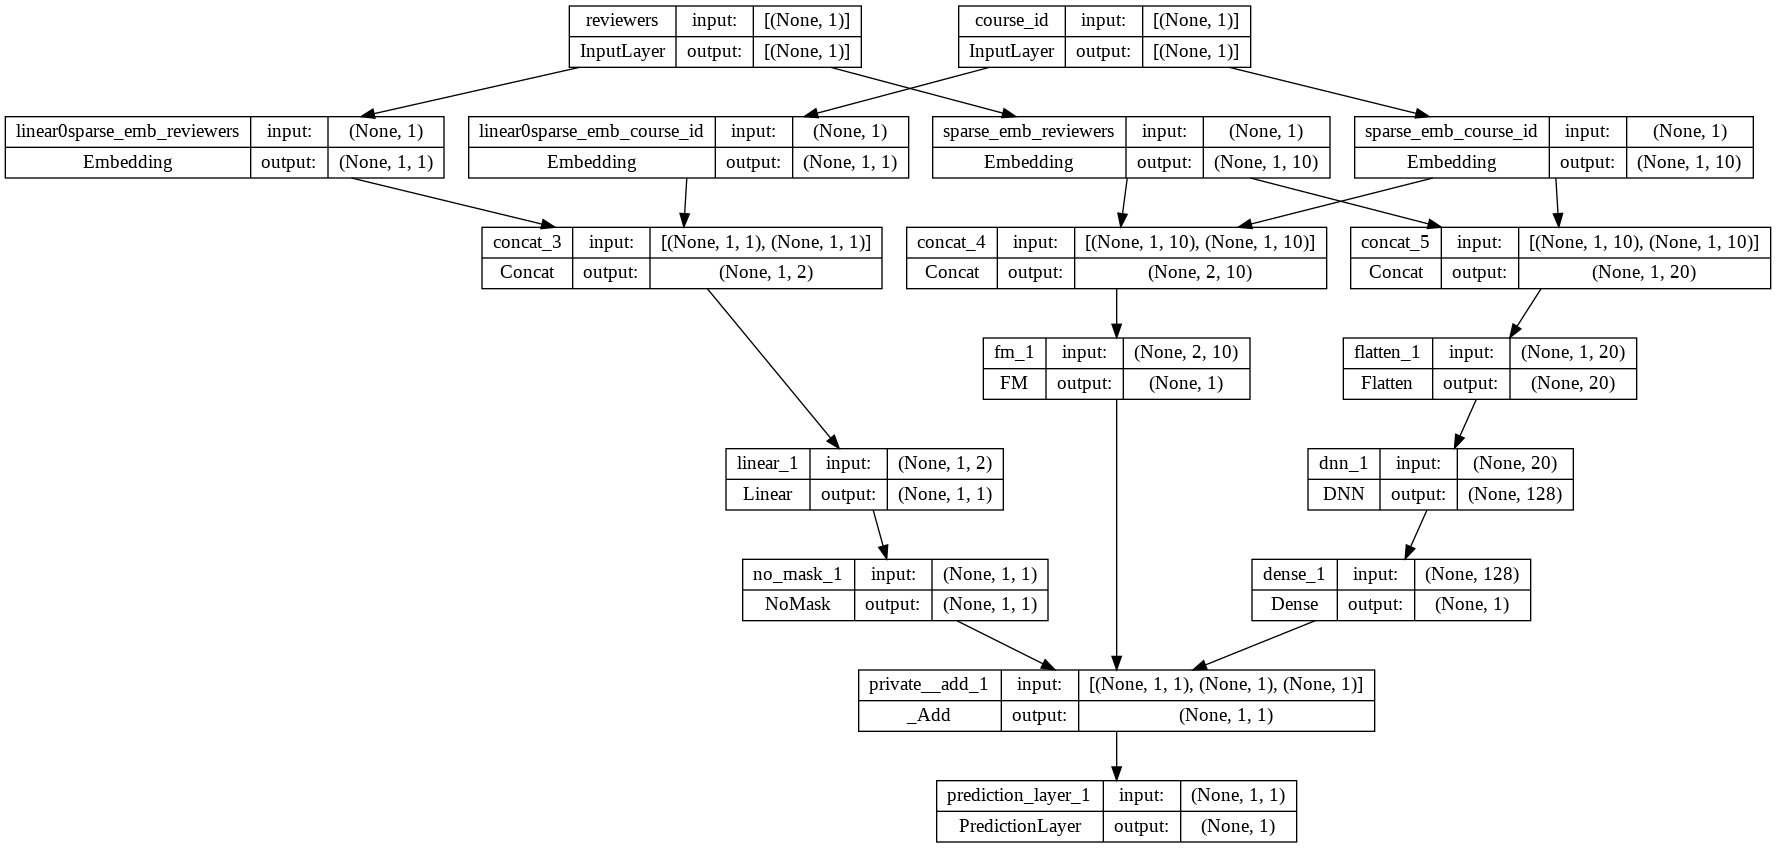

In [ ]:
# 4.Define Model,train,predict and evaluate
model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(128,128),
             seed=1024, dnn_dropout=0.9, dnn_activation='relu', task='regression')
model.compile("adam", "mse", metrics=[keras.metrics.RootMeanSquaredError()])
model.summary()
utils.plot_model(model, to_file='/content/drive/MyDrive/model/deepfm_recommender_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(train_model_input, train[target].values,batch_size=256, epochs=50, verbose=2, validation_split=0.2)

Epoch 1/50


InvalidArgumentError: ignored

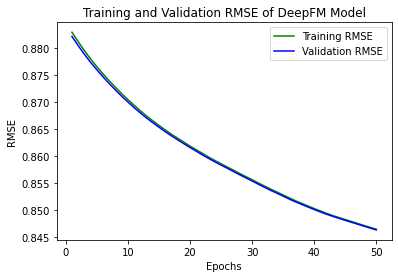

In [ ]:
import matplotlib.pyplot as plt
rmse_train = history.history['root_mean_squared_error']
rmse_val = history.history['val_root_mean_squared_error']
epochs = range(1,51)
plt.plot(epochs, rmse_train, 'g', label='Training RMSE')
plt.plot(epochs, rmse_val, 'b', label='Validation RMSE')
plt.title('Training and Validation RMSE of DeepFM Model')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
pred_ans = model.predict(test_model_input, batch_size=256)
print("test MSE", round(mean_squared_error(test[target].values, pred_ans), 4))
print("test RMSE", math.sqrt(round(mean_squared_error(test[target].values, pred_ans), 4)))
print("test MAE", round(mean_absolute_error(test[target].values, pred_ans), 4))
pred_ans_1d = np.reshape(pred_ans, 209715  )
pred_ans_1d.shape        
np.argsort(np.asarray(pred_ans_1d))[::-1][0:10].tolist()

test MSE 1.2301
test RMSE 1.1090987492858422
test MAE 0.7612


[20051, 145723, 173941, 70046, 56349, 105582, 7237, 181911, 22355, 34086]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
personId (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
contentId (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
sparse_emb_personId (Embedding) (None, 1, 10)        331210      personId[0][0]                   
__________________________________________________________________________________________________
sparse_emb_contentId (Embedding (None, 1, 10)        7089530     contentId[0][0]                  
______________________________________________________________________________________________

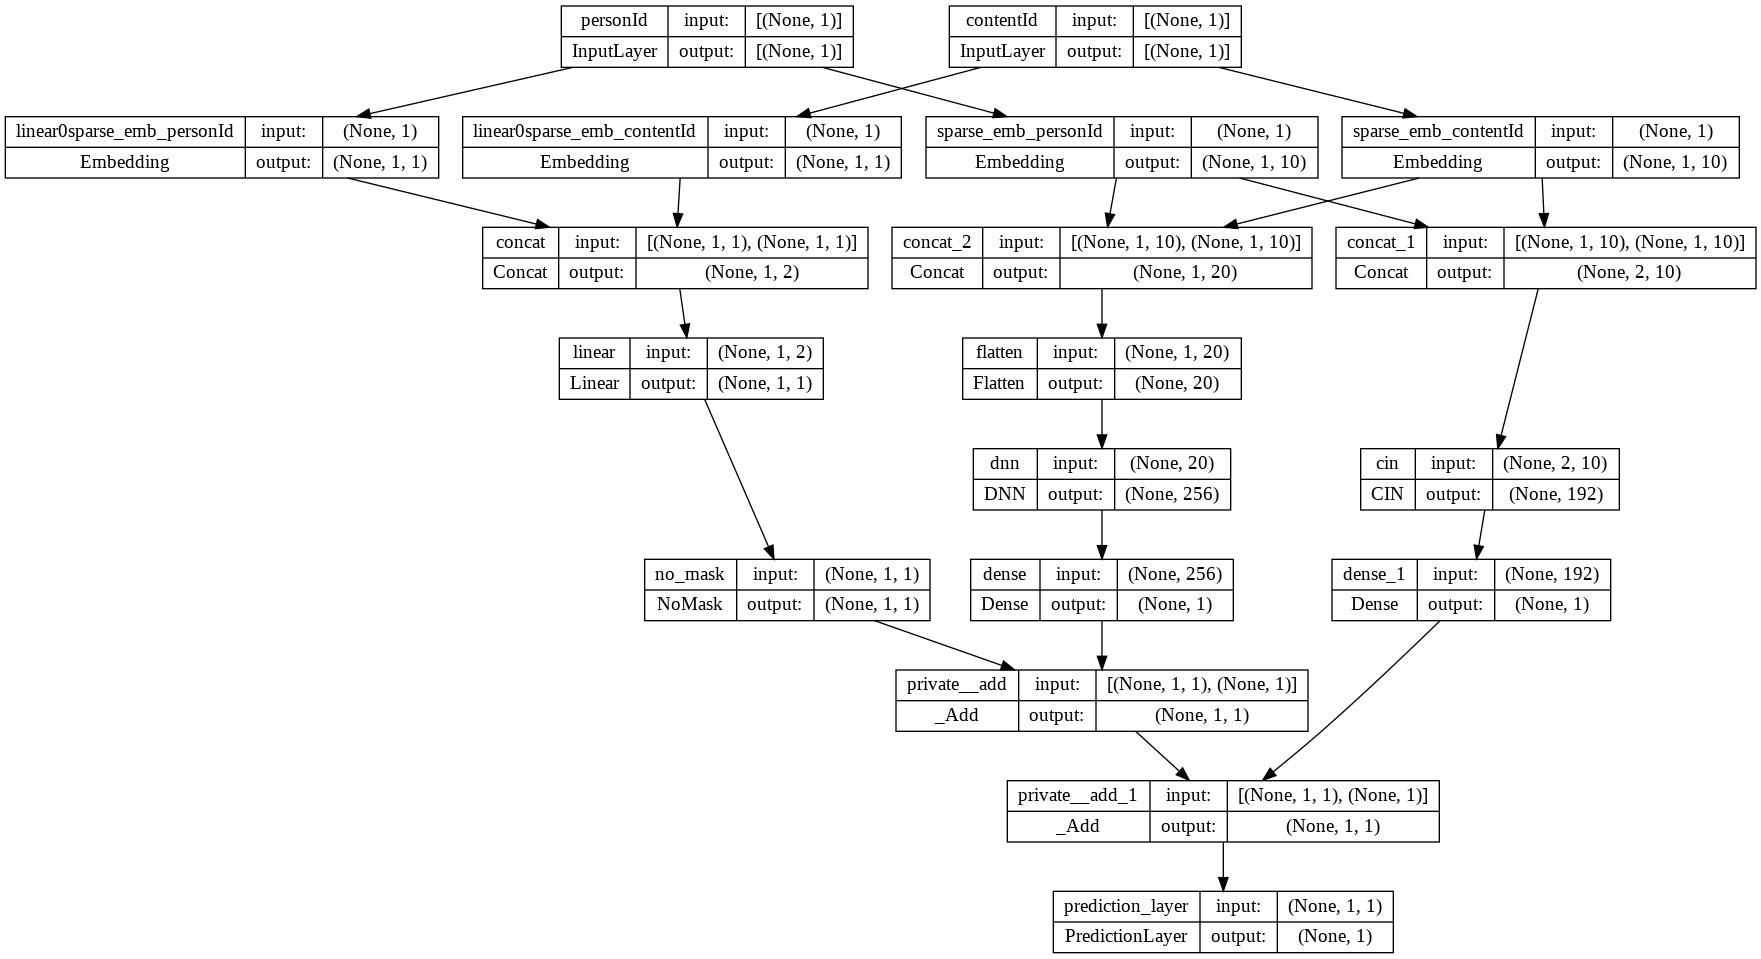

In [ ]:
model = xDeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(256, 256),
                   cin_layer_size=(128, 128), cin_split_half=True, cin_activation='relu', l2_reg_cin=1e-07,
                   seed=1024, dnn_dropout=0.5, dnn_activation='relu', task='regression')
#compiling the model
model.compile("adam", "mse", metrics=[keras.metrics.RootMeanSquaredError()] )
model.summary()
utils.plot_model(model, to_file='/content/drive/MyDrive/model/exdeepfm_recommender_model.png', show_shapes=True, show_layer_names=True)


In [ ]:
# training the model
history = model.fit(train_model_input, train[target].values, batch_size=256, epochs=50, verbose=2, validation_split=0.2 )


Epoch 1/50
2622/2622 - 25s - loss: 1.2581 - root_mean_squared_error: 1.2606 - val_loss: 1.1566 - val_root_mean_squared_error: 1.1102
Epoch 2/50
2622/2622 - 14s - loss: 0.5510 - root_mean_squared_error: 1.0177 - val_loss: 1.1957 - val_root_mean_squared_error: 0.9597
Epoch 3/50
2622/2622 - 14s - loss: 0.5426 - root_mean_squared_error: 0.9289 - val_loss: 1.3003 - val_root_mean_squared_error: 0.9071
Epoch 4/50
2622/2622 - 14s - loss: 0.4641 - root_mean_squared_error: 0.8874 - val_loss: 1.4287 - val_root_mean_squared_error: 0.8736
Epoch 5/50
2622/2622 - 14s - loss: 0.4146 - root_mean_squared_error: 0.8604 - val_loss: 1.4760 - val_root_mean_squared_error: 0.8505
Epoch 6/50
2622/2622 - 14s - loss: 0.3886 - root_mean_squared_error: 0.8409 - val_loss: 1.4196 - val_root_mean_squared_error: 0.8326
Epoch 7/50
2622/2622 - 14s - loss: 0.3464 - root_mean_squared_error: 0.8234 - val_loss: 1.5244 - val_root_mean_squared_error: 0.8170
Epoch 8/50
2622/2622 - 14s - loss: 0.3296 - root_mean_squared_error: 

In [ ]:
#predicting
pred_ans_xdeep = model.predict(test_model_input, batch_size=256, verbose=2)
print("test MSE", round(mean_squared_error(test[target].values, pred_ans_xdeep), 4))
print("test RMSE", math.sqrt(round(mean_squared_error(test[target].values, pred_ans_xdeep), 4)))
print("test MAE", round(mean_absolute_error(test[target].values, pred_ans_xdeep), 4))
pred_ans_1d = np.reshape(pred_ans_xdeep, 209715)
pred_ans_1d.shape        
np.argsort(np.asarray(pred_ans_1d))[::-1][0:10].tolist()

820/820 - 2s
test MSE 1.445
test RMSE 1.2020815280171309
test MAE 0.7685


[132937, 41880, 10451, 163682, 92756, 104862, 131550, 25452, 27126, 14010]

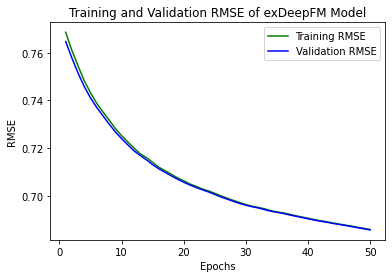

In [ ]:
import matplotlib.pyplot as plt
rmse_train = history.history['root_mean_squared_error']
rmse_val = history.history['val_root_mean_squared_error']
epochs = range(1,51)
plt.plot(epochs, rmse_train, 'g', label='Training RMSE')
plt.plot(epochs, rmse_val, 'b', label='Validation RMSE')
plt.title('Training and Validation RMSE of exDeepFM Model')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics, preprocessing
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Course_reviews.csv')
#ratings = df.groupby(['item', 'user']).mean().reset_index()
df.drop(['date_reviews','reviews'], axis=1, inplace=True)
#df.columns=['studentid','rating','courseid']

df.head(10)

,reviewers,rating,course_id
0,By Robert S,4,google-cbrs-cpi-training
1,By Gabriel E R,4,google-cbrs-cpi-training
2,By Jacob D,4,google-cbrs-cpi-training
3,By Dale B,4,google-cbrs-cpi-training
4,By Sean G,4,google-cbrs-cpi-training
5,By Daniel F,4,google-cbrs-cpi-training
6,By Logan D,5,google-cbrs-cpi-training
7,By Luis M C,5,google-cbrs-cpi-training
8,By scott w,5,google-cbrs-cpi-training
9,By Ryan H,5,google-cbrs-cpi-training


In [ ]:
import math
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, ndcg_score, dcg_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow.keras as keras
from keras import models, layers, utils
from deepctr.models import DeepFM, xDeepFM, DIN
from deepctr.feature_column import SparseFeat, get_feature_names

sparse_features = [ 'course_id','reviewers']
target = ['rating']
# 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    df[feat] = lbe.fit_transform(df[feat])
# 2.count #unique features for each sparse field
fixlen_feature_columns = [SparseFeat(feat, df[feat].max() + 1, embedding_dim=10)
                              for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

# 3.generate input data for model
train, test = train_test_split(df, test_size=0.2)#, random_state=2020)
train_model_input = {name: train[name].values for name in feature_names}
test_model_input = {name: test[name].values for name in feature_names}


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
user_enc = LabelEncoder()
df['reviewers'] = user_enc.fit_transform(df['reviewers'].values)
n_users = df['reviewers'].nunique()
item_enc = LabelEncoder()
df['course_id'] = item_enc.fit_transform(df['course_id'].values)
n_articles = df['course_id'].nunique()
df['rating'] = df['rating'].values.astype(np.float32)

min_rating = min(df['rating'])
max_rating = max(df['rating'])
n_users, n_articles, min_rating, max_rating


X = df[['course_id','reviewers']].values
y = df['rating'].values
#min_max = MinMaxScaler()
#y = min_max.fit_transform(y.reshape(-1,1))[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

n_factors = 2
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]
y_train

(287807, 604, 1.0, 5.0, 5.0)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
course_id (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
reviewers (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
sparse_emb_course_id (Embedding (None, 1, 10)        6040        course_id[0][0]                  
__________________________________________________________________________________________________
sparse_emb_reviewers (Embedding (None, 1, 10)        2878080     reviewers[0][0]                  
____________________________________________________________________________________________

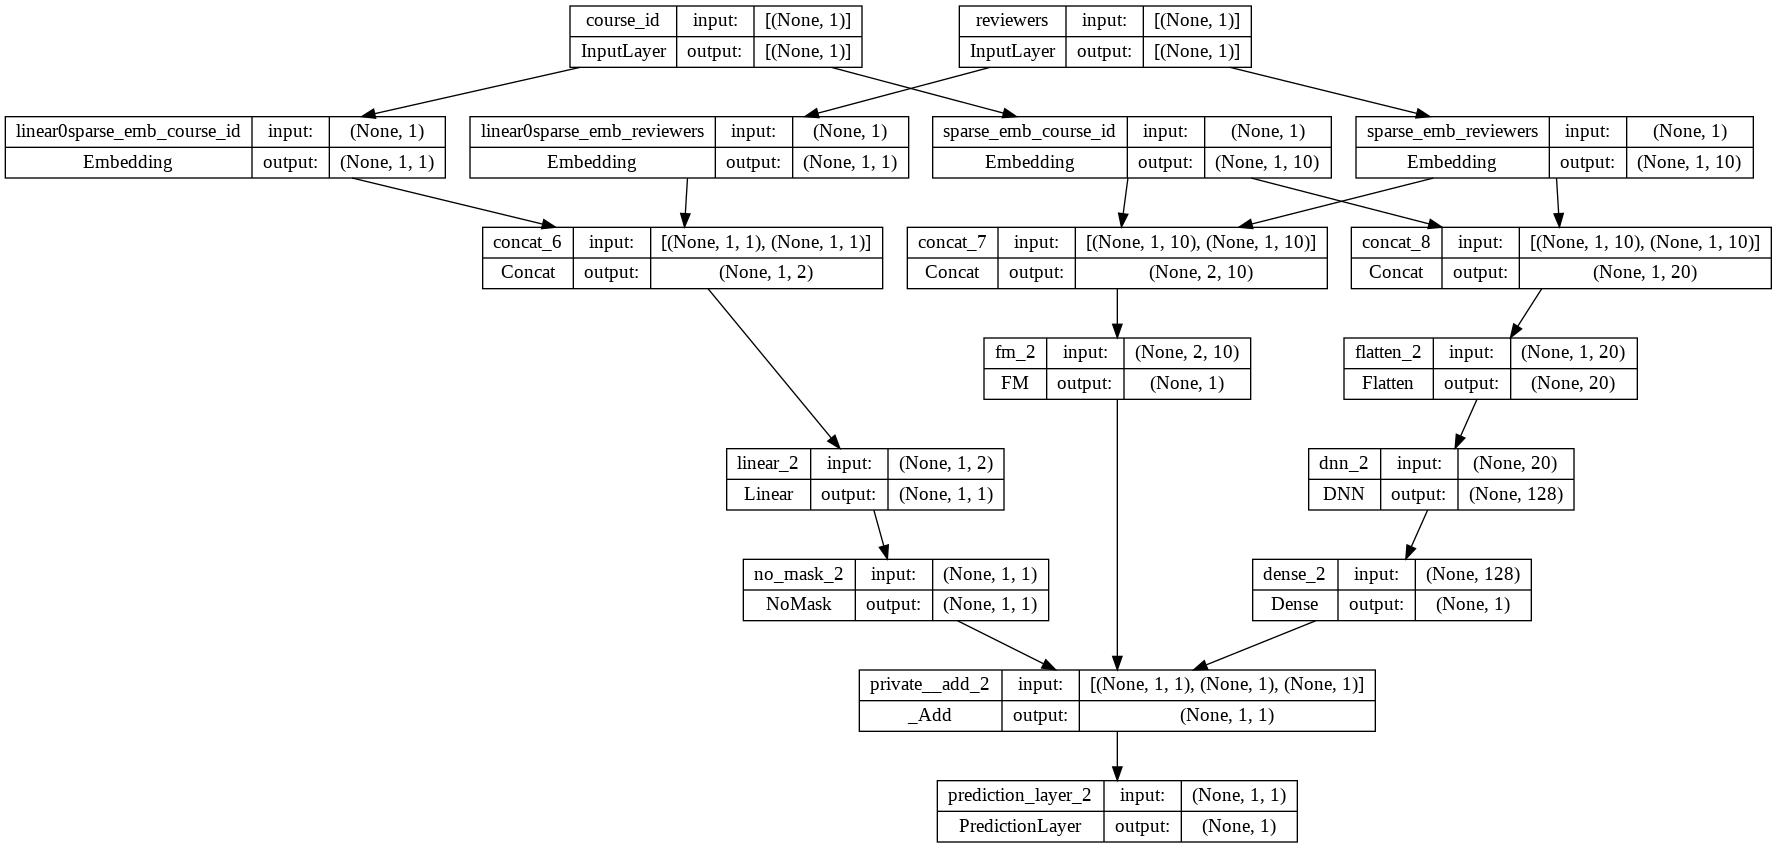

In [ ]:
# 4.Define Model,train,predict and evaluate
model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(128,128),
             seed=1024, dnn_dropout=0.9, dnn_activation='relu', task='regression')
model.compile("adam", "mse", metrics=[keras.metrics.RootMeanSquaredError()])
model.summary()
utils.plot_model(model, to_file='/content/drive/MyDrive/model/deepfm_recommender_model.png', show_shapes=True, show_layer_names=True)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
course_id (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
reviewers (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
sparse_emb_course_id (Embedding (None, 1, 10)        6040        course_id[0][0]                  
__________________________________________________________________________________________________
sparse_emb_reviewers (Embedding (None, 1, 10)        2878080     reviewers[0][0]                  
____________________________________________________________________________________________

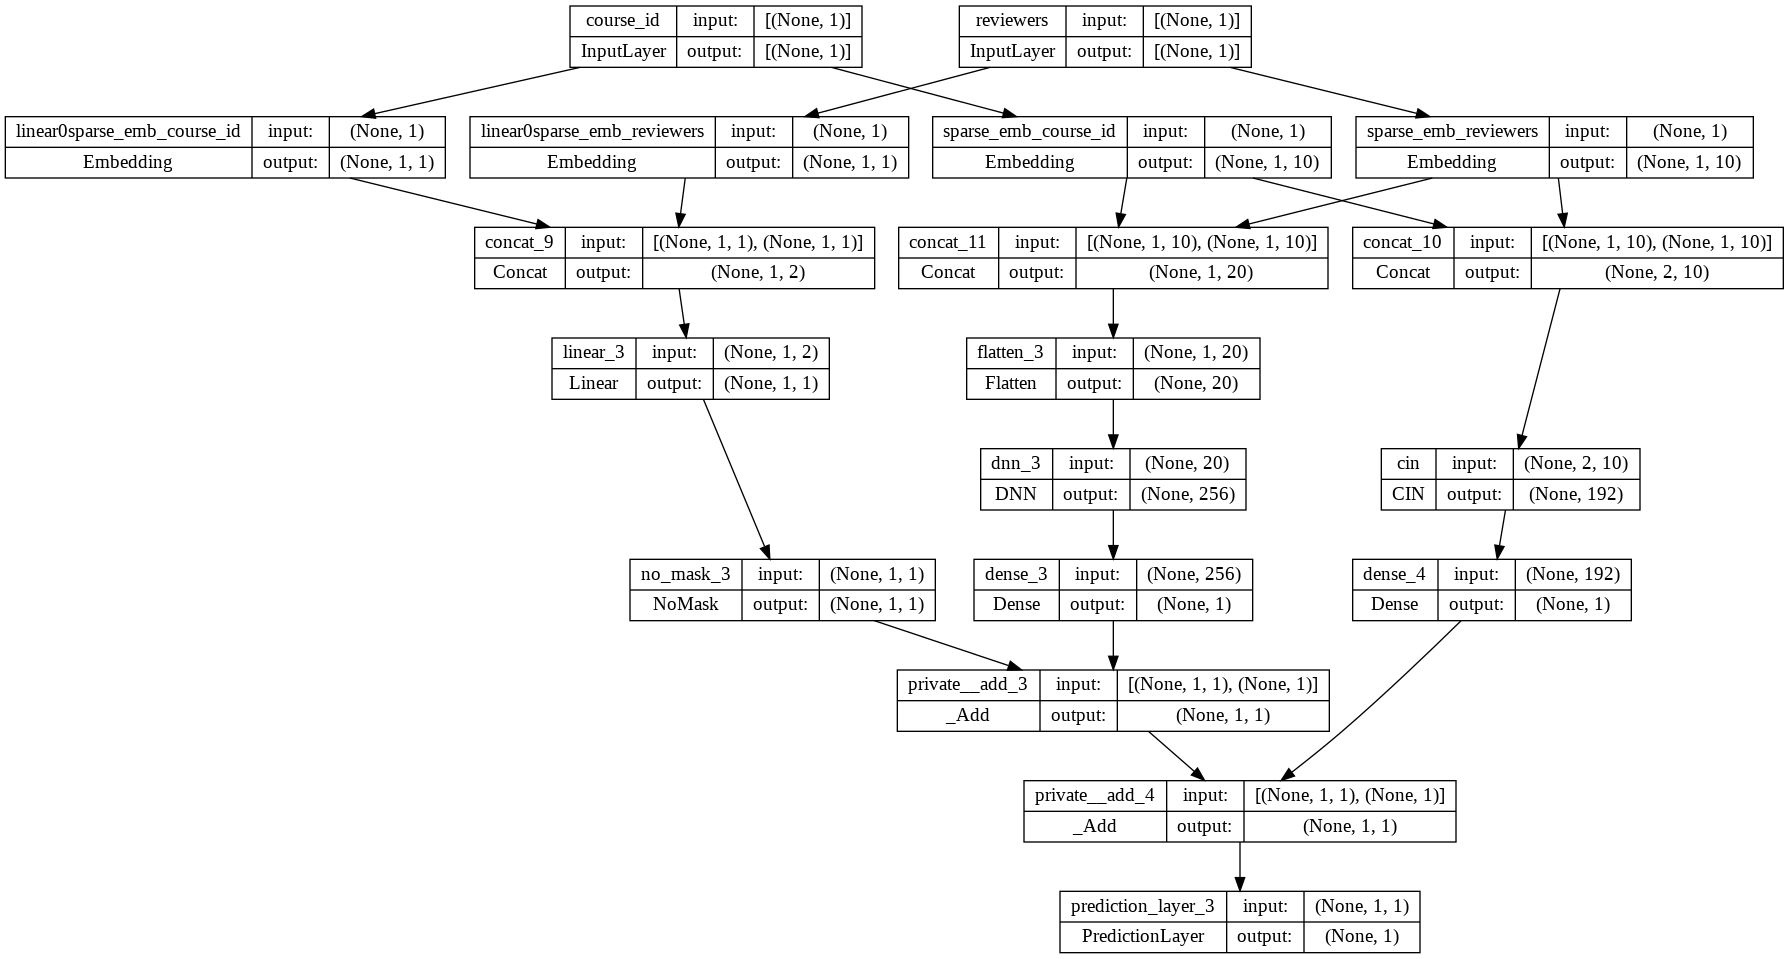

In [ ]:
model = xDeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(256, 256),
                   cin_layer_size=(128, 128), cin_split_half=True, cin_activation='relu', l2_reg_cin=1e-07,
                   seed=1024, dnn_dropout=0.5, dnn_activation='relu', task='regression')
#compiling the model
model.compile("adam", "mse", metrics=[keras.metrics.RootMeanSquaredError()] )
model.summary()
utils.plot_model(model, to_file='/content/drive/MyDrive/model/exdeepfm_recommender_model.png', show_shapes=True, show_layer_names=True)


In [ ]:
history = model.fit(train_model_input, train[target].values,batch_size=256, epochs=10, verbose=2, validation_split=0.2)

Epoch 1/10
3637/3637 - 139s - loss: 0.4708 - root_mean_squared_error: 0.8785 - val_loss: 0.3289 - val_root_mean_squared_error: 0.6676
Epoch 2/10
3637/3637 - 136s - loss: 0.2567 - root_mean_squared_error: 0.6170 - val_loss: 0.2864 - val_root_mean_squared_error: 0.5856
Epoch 3/10
3637/3637 - 137s - loss: 0.2033 - root_mean_squared_error: 0.5603 - val_loss: 0.2514 - val_root_mean_squared_error: 0.5409
Epoch 4/10
3637/3637 - 137s - loss: 0.1643 - root_mean_squared_error: 0.5225 - val_loss: 0.2326 - val_root_mean_squared_error: 0.5082
Epoch 5/10
3637/3637 - 135s - loss: 0.1475 - root_mean_squared_error: 0.4948 - val_loss: 0.2224 - val_root_mean_squared_error: 0.4842
Epoch 6/10
3637/3637 - 145s - loss: 0.1372 - root_mean_squared_error: 0.4740 - val_loss: 0.2219 - val_root_mean_squared_error: 0.4660
Epoch 7/10
3637/3637 - 138s - loss: 0.1301 - root_mean_squared_error: 0.4579 - val_loss: 0.2103 - val_root_mean_squared_error: 0.4514
Epoch 8/10
3637/3637 - 142s - loss: 0.1257 - root_mean_squared

In [ ]:
from sklearn.metrics import log_loss, roc_auc_score

#predicting
pred_ans_xdeep = model.predict(test_model_input, batch_size=256, verbose=2)
print("test MSE", round(mean_squared_error(test[target].values, pred_ans_xdeep), 4))
print("test RMSE", math.sqrt(round(mean_squared_error(test[target].values, pred_ans_xdeep), 4)))
print("test MAE", round(mean_absolute_error(test[target].values, pred_ans_xdeep), 4))
pred_ans_1d = np.reshape(pred_ans_xdeep, 290943)
pred_ans_1d.shape        
np.argsort(np.asarray(pred_ans_1d))[::-1][0:10].tolist()

1137/1137 - 10s
test MSE 0.1777
test RMSE 0.42154477816715985
test MAE 0.216


[7437, 241472, 16654, 48789, 31157, 152816, 10870, 285869, 225106, 73842]

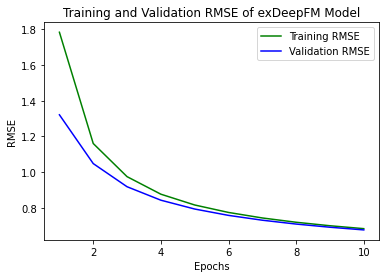

In [ ]:
import matplotlib.pyplot as plt
rmse_train = history.history['root_mean_squared_error']
rmse_val = history.history['val_root_mean_squared_error']
epochs = range(1,11)
plt.plot(epochs, rmse_train, 'g', label='Training RMSE')
plt.plot(epochs, rmse_val, 'b', label='Validation RMSE')
plt.title('Training and Validation RMSE of exDeepFM Model')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

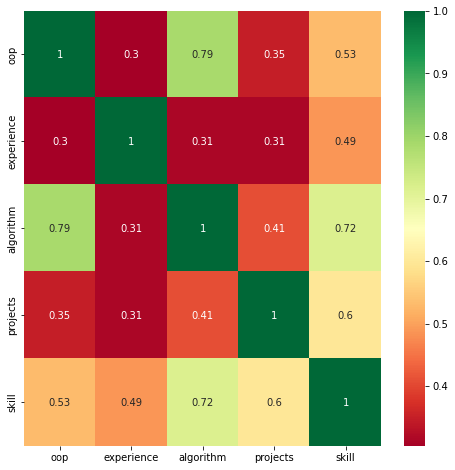

In [ ]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics, preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/ProgrammingSkill.csv')
df.head(10)
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn')
plt.show()

              precision    recall  f1-score   support

    Beginner       0.90      0.96      0.93        27
    Midlevel       0.71      0.75      0.73        16
      Expert       0.75      0.43      0.55         7

    accuracy                           0.82        50
   macro avg       0.78      0.71      0.73        50
weighted avg       0.82      0.82      0.81        50



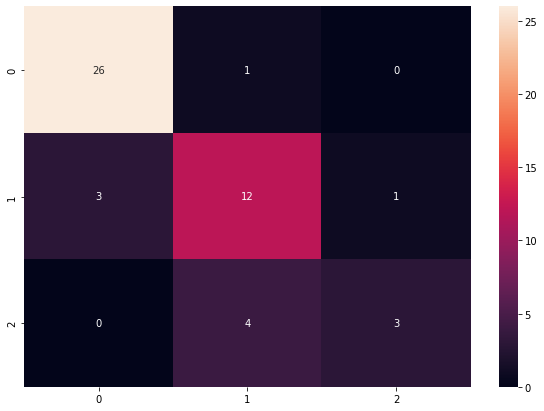

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

true = df['skill'].values
pred = np.array([1,2,2,1,1,1,1,2,1,2,1,1,2,2,1,2,1,1,2,1,1,2,1,1,1,1,2,2,1,2,2,1,1,3,1,2,2,3,3,2,1,3,1,1,1,1,1,1,1,2])
labels = np.array([1,2,3])
target_names = ["Beginner","Midlevel","Expert"]

clf_report = classification_report(true,
                                   pred,
                                   labels=labels,
                                   target_names=target_names,
                                   output_dict=False)

#sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
print(clf_report)
cf_matrix = confusion_matrix(true, pred)
df1 = pd.DataFrame(cf_matrix)
plt.figure(figsize=(10,7))
sns.heatmap(df1, annot=True)
plt.show()



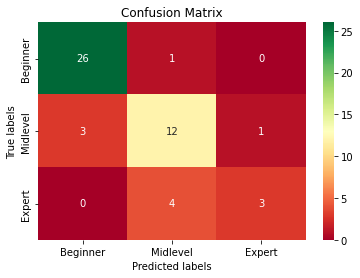

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax, cmap='RdYlGn');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(["Beginner","Midlevel","Expert"]); ax.yaxis.set_ticklabels(["Beginner","Midlevel","Expert"]);